In [1]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [3]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '../data'
annotation_csv = '../data/annotation.csv'

In [4]:
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

In [5]:
transform = torchvision.transforms.ToTensor()

unlabeled_trainset = UnlabeledDataset(image_folder=image_folder, scene_index=labeled_scene_index, first_dim='sample', transform=transform)
trainloader = torch.utils.data.DataLoader(unlabeled_trainset, batch_size=3, shuffle=True, num_workers=2)

In [6]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [7]:
sample, target, road_image, extra = iter(trainloader).next()
print(torch.stack(sample).shape)

torch.Size([2, 6, 3, 256, 306])


# Bounding Box Transformation (Work in Progress)


The corners are in meter and time 10 will convert them in pixels.

Add 400, since the center of the image is at pixel (400, 400). 

The negative sign is because the y axis is reversed for matplotlib.

In [8]:
#batch = 1
def bb_to_image(num_batches,target):
    image_batch = []
    for batch in range(num_batches):

        # Initialize tensor to store (800 x 800) image of binary top-down view
        tensor_grid = torch.zeros((800,800))

        # Convert target coordinates from meters to pixels:
        coordinates = target[batch]['bounding_box']*10+400
        # Flip y axis (since the y-axis is reversed for matplotlib)
        coordinates[0][1,:] = -coordinates[0][1,:] 

        # Extract a single object
        obj_idx = 0
        object_in_question = coordinates[obj_idx]

        # Store as array, round up/down pixel coordinates and set to integers
        object_in_question = np.array(np.around(object_in_question,0)).astype(int)

        # The coordinates are ordered as follows (first quadrant wrt ego car is front left) 
        # NEED TO DOUBLE CHECK THE NAMING BUT IT WORKS
        # FL: front left, FR: front right, BL: back left, BR: back right
        [FL_x, FR_x, BL_x, BR_x] = [i for i in object_in_question[0]]
        [FL_y, FR_y, BL_y, BR_y] = [i for i in object_in_question[1]]

        # width of vehicle is given by the difference in y between the back left corner and the back right corner.
        # We choose the min to make sure we start slicing at the smaller index
        width_start = np.min([BL_y, BR_y])
        # length of vehicle is given by the difference in x between the back left corner and the front left corner
        length_start = np.min([BL_x, FL_x])

        # Define matrix indices to slice tensor
        indices = [width_start,width_start+np.abs(BL_y - BR_y),length_start,length_start+np.abs(BL_x - FL_x)]

        # Fill in sliced tensor with 1's
        tensor_grid[indices[0]:indices[1],indices[2]:indices[3]].fill_(1)

        assert tensor_grid[indices[0]][indices[2]] == 1
        image_batch.append(tuple([batch,tensor_grid]))
    
    return image_batch

In [9]:
out = bb_to_image(2,target)

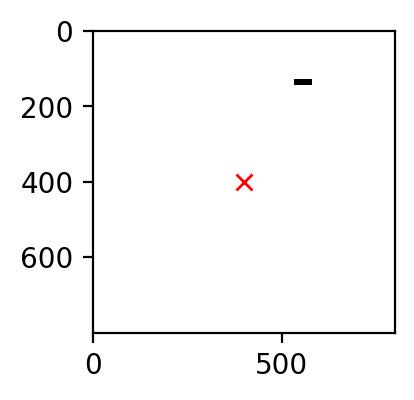

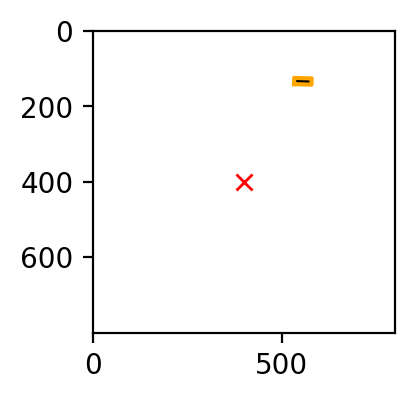

In [10]:
# The center of image is 400 * 400
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

fig, ax = plt.subplots(figsize=(2,2))

ax.imshow(out[0][1], cmap ='binary');
# The ego car position
ax.plot(400, 400, 'x', color="red")

fig, ax = plt.subplots(figsize=(2,2))
# The ego car position
ax.plot(400, 400, 'x', color="red")
ax.imshow(out[0][1], cmap ='binary');
draw_box(ax, target[0]['bounding_box'][0], color=color_list[target[0]['category'][0]]) 

# fig, ax = plt.subplots(figsize=(2,2))

# ax.imshow(road_image[batch], cmap ='binary');
# # The ego car position
# ax.plot(400, 400, 'x', color="red")
# draw_box(ax, target[batch]['bounding_box'][0], color=color_list[target[0]['category'][i]]) 
